# Práctica de clasificación

## Contacto

* Nombre: Jorge Cabrera Rodríguez
* Email: alu0101351773@ull.edu.es
* Universidad: Universidad de La Laguna
* Grado: Ingeniería Informática
* Repositorio: [enlace](https://github.com/alu0101351773/ECBD_practicas.git)

## Introducción al _dataset_

Este proyecto trbaja con una base de datos llamada `homeLoanAproval.csv`, que
contiene información detallada sobre los créditos bancarios concedidos a 614
usuarios de una entidad bancaria desconocida. Esta base de datos cuenta con
valores como puedan ser, entre otros:

* El estado civil del usuario (`Married`)
* EL nivel educativo del solicitante (`Education`)
* El importe del crédito solicitado (`LoanAmount`)
* El número de personas que dependan del solicitante (`Dependents`)
* El estado del crédito (`Loan_Status`) (Aprobado o denegado)

Con esta base de datos se busca construir un sistema que sea capaz de ayudar en
la tarea de concesión de créditos bancarios para futuros usuarios, de tal forma
que para unos datos de entrada desconocidos para el sistema, este sea capaz de
predecir si el crédito será aprobado o denegado.

## Desarrollo del proyecto

### Visualización de datos

#### Carga de datos

La primera tarea a realizar con la base de datos es realizar una visualización
inicial, para observar los datos con los que trabajamos, así como sus deficiencias
y posibles problemas que puedan surgir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('../data/Base de datos - homeLoanAproval.csv')
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,PropertyArea,LoanStatus
0,LP001002,Male,No,0,Graduate,No,5849,0,NaN,360.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128.0,360.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66.0,360.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120.0,360.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0,141.0,360.0,Urban,Y


In [3]:
print(f'Tamaño del dataset: {dataset.shape}')

Tamaño del dataset: (614, 12)


En la primera visualización podemos observar que el dataset cuenta con 614
registros y 12 variables por cada registro. De estas 12 variables, 11 son
variables de entrada y 1 es la variable de salida, que es la que se pretende
predecir (`LoanStatus`).

#### Recuento de valores nulos

Contaremos el número de valores
nulos que contiene cada variable, con el objetivo de analizar si es necesario
realizar algún tipo de tratamiento de datos para eliminar estos valores nulos.

In [4]:
pd.DataFrame.from_dict(
    data = {
        'Tipo de dato': dataset.dtypes,
        'Valores faltantes (NA)': dataset.isna().sum(),
    },
    orient = 'columns'
)

,Tipo de dato,Valores faltantes (NA)
Loan_ID,object,0
Gender,object,13
Married,object,3
Dependents,object,15
Education,object,0
SelfEmployed,object,32
ApplicantIncome,int64,0
CoapplicantIncome,object,0
LoanAmount,float64,22
LoanAmountTerm,float64,14


Podemos observar que la base de datos cuenta con bastantes valores nulos, por lo
que será necesario algún tipo de preprocesado para poder reducir su número.

#### Análisis de valores atípicos

Además de los valores nulos, también es necesario analizar los valores atípicos
(_outliers_) que puedan existir en la base de datos. Para ello, se ha realizado
un análisis de los valores atípicos de las variables numéricas, que son las
siguientes:

* `ApplicantIncome`
* `LoanAmount`
* `LoanAmountTerm`

Para este análisis, se ha utilizado el diagrama de cajas (_boxplot_), que nos
permite observar los valores atípicos de una variable de forma visual.

Text(0.5, 1.0, 'LoanAmountTerm')

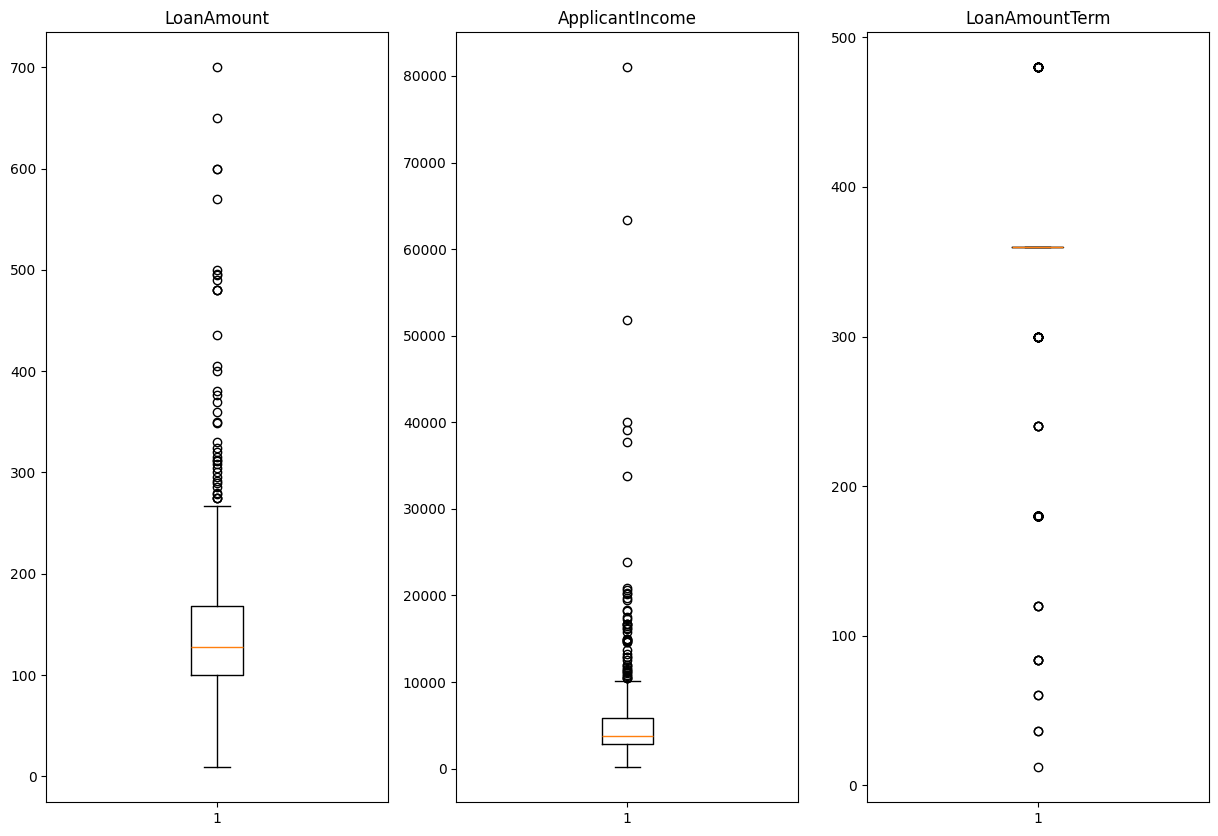

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 10))

ax[0].boxplot(dataset['LoanAmount'].dropna())
ax[0].set_title('LoanAmount')

ax[1].boxplot(dataset['ApplicantIncome'])
ax[1].set_title('ApplicantIncome')

ax[2].boxplot(dataset['LoanAmountTerm'].dropna())
ax[2].set_title('LoanAmountTerm')

Según se puede observar, la variable `CoapplicantIncome` no se ha incluido en
el análisis de outliers, pues aunque contenga números, estos están expresados
como cadenas de texto, por lo que se debe analizar únicamente tras haber
realizado el preprocesado de datos.

Para corregir esta variable antes de comenzar el preproceasdo persé, se
realizará una pequeña limpieza de datos en la que se formateará la variable a
números, eliminando puntos y comas, y convirtiendo la variable a tipo numérico.

{'whiskers': [<matplotlib.lines.Line2D at 0x2492b7ef010>,
 'caps': [<matplotlib.lines.Line2D at 0x2492b7f83d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2492b7ee6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x2492b7f99d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2492b7fa510>],
 'means': []}

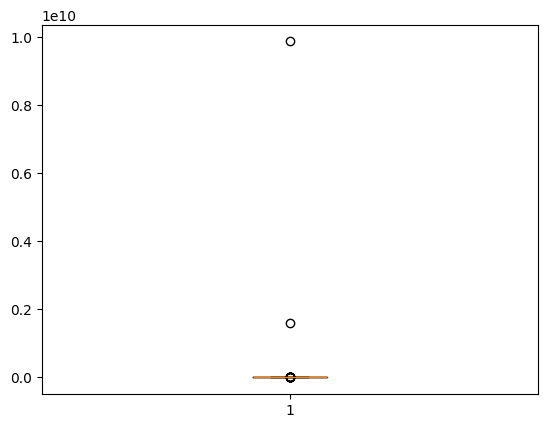

In [6]:
if dataset['CoapplicantIncome'].dtype is not np.dtype('int64'):
    dataset['CoapplicantIncome'] = dataset['CoapplicantIncome'].apply(lambda x: int(x.replace('.', '')))

fig, ax = plt.subplots()

ax.boxplot(dataset['CoapplicantIncome'])

Como se observa en el diagrama de cajas de la variable `CoapplicantIncome`, esta
cuenta con pocos valores atípicos, pero muy alejados del promedio de valores, lo
que podrá (y seguramente lo hará) afectar al modelo de clasificación generado.

#### Balance de clases

Como último paso de visualización de datos, puede ser interesante analizar el
balance de clases de la variable de salida `LoanStatus`, para observar si
existe un desbalance que pueda afectar al modelo de clasificación.

In [7]:
pd.DataFrame.from_dict(
    data = {
        'Registros': dataset['LoanStatus'].value_counts(),
        'Porcentaje (%)': dataset['LoanStatus'].value_counts(normalize = True).apply(lambda x: round(x * 100, 2)),
    },
    orient = 'columns'
)

,Registros,Porcentaje (%)
LoanStatus,,
Y,422,68.73
N,192,31.27


Podemos observar un desbalance de clases moderado, pues casi un 70% de las
entradas pertenecen a la clase de créditos aprobados (`Y`), mientras que el
resto pertenecen a la clase de créditos denegados (`N`).

Siendo un desbalance no tan marcado, es probable que no influya demasiado en el
modelo de clasificación. Sin embargo, sería interesante más adelante realizar un
entrenamiento del modelo con y sin balanceo de clases, para observar si existe
alguna mejora en el rendimiento del mismo.

### Preprocesado de datos

#### Eliminación de variables innecesarias

El primer paso de la fase de preprocesado será la eliminación de aquellas
variables que no aporten información al modelo, o sean irrelevantes por su
propia naturaleza.

En este caso en particular, todas las variables aportan información sobre los
clientes que puede ser relevante; todas menos la variable `LoanID`, pues es un
valor serial que se genera de forma automática para cada registro, y no aporta
ninguna información útil para un modelo de clasificación.

In [8]:
if 'Loan_ID' in dataset.columns:
    dataset.drop(columns = ['Loan_ID'], inplace = True)
dataset.head()

,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,PropertyArea,LoanStatus
0,Male,No,0,Graduate,No,5849,0,NaN,360.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508,128.0,360.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0,66.0,360.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358,120.0,360.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0,141.0,360.0,Urban,Y


#### Corrección de valores faltantes

Tras haber eliminado las variables innecesarias, se procederá a corregir los
valores faltantes de las variables restantes. Para esto, podemos realizar
múltiples operaciones:

* Para las variables numéricas:
    * Media de sus valores
    * Mediana de sus valores
    * Moda global de sus valores
* Para las variables categóricas:
    * Moda global de sus valores

Alternativamente a estas técnicas sencillas, podemos utilizar técnicas que tengan
en cuenta otras variables, como pueda ser:

* Cálculo de la media acorde al `LoanStatus`
* Cálculo de la mediana acorde al `LoanStatus`
* Cálculo de la moda acorde al `LoanStatus`

Para este caso en particular, se ha decidido generar dos datasets diferentes,
uno con diferentes procesados basados en valores de centralización, y otro
eliminando todos aquellos registros con valores nulos.

<!-- TODO: Revisar esta descripción porque da penita -->

#### Etiquetado

#### Corrección de _outliers_

#### Balance de clases

### Definición de modelos

#### Creación de modelos

#### Entrenamiento de modelos

#### Evaluación de modelos

## Conclusiones extraídas